In [9]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import h5py 
import scipy.fftpack
from scipy.ndimage import rotate
from deepinpy.opt import ConjGrad


In [10]:
#!/usr/bin/env python

'''
Utility functions """
'''
# FIXME: Some methods use sub-methods that have optional param axes, axes should also be added to these methods

def h5_inspect(filename):
    with h5py.File(filename, 'r') as F:
        for key in F.keys():
            print(key, F[key].shape)

def h5_write(filename, data):
    """Read numpy arrays from h5 file.

    Args:
        filename (str): Path to the file
        data (dict): Dictionary of data to save
        
    """
    with h5py.File(filename, 'w') as F:
        for key in data.keys():
            F.create_dataset(key, data=data[key])

def h5_read(filename, key_list):
    """Read numpy arrays from h5 file.

    Args:
        filename (str): Path to the file
        key_list (list): List of keys to open

    Returns:
        A dictionary of numpy arrays matching key_list
    """
    data = {}
    with h5py.File(filename, 'r') as F:
        for key in key_list:
            try:
                data[key] = np.array(F[key])
            except:
                print('Key {} not found in {}. Skipping.'.format(key, filename))
                data[key] = None
    return data

# TODO: Unused, potentially depreciated
# FIXME: Dim should be an optional parameter for consistency with torch.topk
def topk(inp, k, dim):
    """Finds the top k values of a vector along a specified dimension.

    Args:
        inp (torch.Tensor): The tensor to retrieve the top k values from.
        k (int): The number of values to retrieve.
        dim (int): The dimension of the Tensor the values should be retrieved from.

    Returns:
        A Tensor of the same shape as the original containing only the top k values.
    """
    _topk, _idx = torch.topk(abs(inp), k, dim=dim)
    _topk = torch.gather(inp, dim, _idx).sign() * _topk
    out = 0*inp
    return out.scatter_(dim, _idx, _topk)

def t2n2(x):
    """Converts a Tensor into a numpy array directly.

    Args:
        x (Tensor): The Tensor to convert.

    Returns:
        A numpy array initialized from x which has been detached from its computational graph.
    """

    return np.array(x.detach().cpu())

def itemize(x):
    """Converts a Tensor into a list of Python numbers.

    Args:
        x (Tensor): The tensor being itemized.

    Returns:
        Python list containing the itemized contents of the tensor.
    """

    if len(x.shape) < 1:
        x = x[None]
    if x.shape[0] > 1:
        return [xx.item() for xx in x]
    else:
        return x.item()

def fftmod(out):
    """Performs a modulated FFT on the input, that is multiplying every other line by exp(j*pi) which is a shift of N/2, hence modulating the output by +/- pi.

    Args:
        out (array_like): Input to the FFT.

    Returns:
        The modulated FFT of the input.
    """

    out2 = out.copy()
    out2[...,::2,:] *= -1
    out2[...,:,::2] *= -1
    out2 *= -1
    return out2

def fftshift(x, axes=(-2, -1)):
    """Shifts the zero-frequency component of the last two dimensions of the input to the center of the spectrum.

    Args:
        x (array_like): The vector to be shifted.
        axes (array_like): The axes along which to apply the shift, default (-2, -1), None uses all axes.

    Returns:
        The shifted version of x.
    """

    return scipy.fftpack.fftshift(x, axes=axes)

def ifftshift(x, axes=(-2, -1)):
    """Removes the effects of shifting the zero-frequency component of the last two dimensions of the input to the center of the spectrum.

    Args:
        x (array_like): The vector whose shift is to be removed.
        axes (array_like): The axes along which to apply the shift, default (-2, -1), None uses all axes.

    Returns:
        An unshifted version of x.
    """

    return scipy.fftpack.ifftshift(x, axes=axes)

def fft2c(x):
    """Performs a 2-dimensional centered FFT on the last two dimensions of the input.

    Args:
        x (array_like): The values to be transformed.

    Returns:
        The 2-dimensional centered FFT of x.
    """

    return fftshift(fft2(ifftshift(x)))

def ifft2c(x):
    """Performs an inverse 2-dimensional centered FFT on the last two dimensions of the input.

    Args:
        x (array_like): The values to be transformed.

    Returns:
        The inverse 2-dimensional centered FFT of x.
    """
    return ifftshift(ifft2(fftshift(x)))

def fft2uc(x):
    """Performs a unitary-centered 2-dimensional FFT on the last two dimensions of the input.

    Args:
        x (array_like): The values to be transformed.

    Returns:
        The unitary-centered 2-dimensional FFT of x.
    """
    return fft2c(x) / np.sqrt(np.prod(x.shape[-2:]))

def ifft2uc(x):
    """Performs an inverse unitary-centered 2-dimensional FFT on the last two dimensions of the input.

    Args:
        x (array_like): The values to be transformed.

    Returns:
        The inverse unitary-centered 2-dimensional FFT of x.
    """

    return ifft2c(x) * np.sqrt(np.prod(x.shape[-2:]))

def fft2(x, axes=(-2, -1)):
    """Performs a 2-dimensional FFT on the last two dimensions of the input.

    Args:
        x (array_like): The values to be transformed.
        axes (array_like): The axes along which to apply the shift, default (-2, -1), None uses all axes.

    Returns:
        The 2-dimensional FFT of x.
    """

    return scipy.fftpack.fft2(x, axes=axes)

def ifft2(x, axes=(-2, -1)):
    """Performs an inverse 2-dimensional FFT on the last two dimensions of the input.

    Args:
        x (array_like): The values to be transformed.
        axes (array_like): The axes along which to apply the shift, default (-2, -1), None uses all axes.

    Returns:
        The inverse 2-dimensional FFT of x.
    """

    return scipy.fftpack.ifft2(x, axes=axes)


#!/usr/bin/env python
"""Data transformation and processing class with functions."""

import numpy as np
import torch.fft
import torch

class MultiChannelMRI(torch.nn.Module):
    """Class which implements a forward operator (matrix A) for data processing and transformation.

    This class performs signal processing functions and various transformations such as masking to data passed to it,
    which prepares it for model processing. Because it extends a nn.Module, it can be wired into the Recon as part of
    the System block.

    Args:
        maps (...): The sensitivity profiles for each MRI coil.
        mask (...): The mask to incoherently subsample k-space.
        img_shape (tuple): Dimensions of image.
        use_sigpy (boolean): Whether or not to use the sigpy package for processing.
        noncart (boolean): ...

    Attributes:
        maps (...): The sensitivity profiles for each MRI coil.
        mask (...): The mask to incoherently subsample k-space.
        img_shape (tuple): Dimensions of image.
        use_sigpy (boolean): Whether or not to use the sigpy package for processing.
        noncart (boolean): ...
    """

    def __init__(self, maps, mask, l2lam=False, img_shape=None, use_sigpy=False, noncart=False, num_spatial_dims=2):
        super(MultiChannelMRI, self).__init__()
        self.maps = maps
        self.mask = mask
        self.l2lam = l2lam
        self.img_shape = img_shape
        self.noncart = noncart
        self._normal = None
        self.num_spatial_dims = num_spatial_dims

        if self.maps.shape[1] == 1:
            self.single_channel = True
        else:
            self.single_channel = False
            
        if self.noncart:
            assert use_sigpy, 'Must use SigPy for NUFFT!'

        if use_sigpy: # FIXME: Not yet Implemented for 3D
            from sigpy import from_pytorch, to_device, Device
            sp_device = Device(self.maps.device.index)
            self.maps = to_device(from_pytorch(self.maps, iscomplex=True), device=sp_device)
            self.mask = to_device(from_pytorch(self.mask, iscomplex=False), device=sp_device)
            self.img_shape = self.img_shape[:-1] # convert R^2N to C^N
            self._build_model_sigpy()

        #if normal is None:
            #self.normal_fun = self._normal
        #else:
            #self.normal_fun = normal

    def _build_model_sigpy(self):
        from sigpy.linop import Multiply
        if self.noncart:
            from sigpy.linop import NUFFT, NUFFTAdjoint
        else:
            from sigpy.linop import FFT
        from sigpy import to_pytorch_function

        if self.noncart:
            Aop_list = []
            Aop_adjoint_list = []
            Aop_normal_list = []
            _img_shape = self.img_shape[1:]
            for i in range(self.img_shape[0]):
                _maps = self.maps[i, ...]
                _mask = self.mask[i, ...]
                Sop = Multiply(_img_shape, _maps)
                Fop = NUFFT(_maps.shape, _mask)
                Aop = Fop * Sop
                Fop_H = NUFFTAdjoint(_maps.shape, _mask)

                Aop_H = Sop.H * Fop_H
                Aop_list.append(to_pytorch_function(Aop, input_iscomplex=True, output_iscomplex=True).apply)
                Aop_adjoint_list.append(to_pytorch_function(Aop_H, input_iscomplex=True, output_iscomplex=True).apply)
                Aop_normal_list.append(to_pytorch_function(Aop_H * Aop, input_iscomplex=True, output_iscomplex=True).apply)

            self.Aop_list = Aop_list
            self.Aop_adjoint_list = Aop_adjoint_list
            self.Aop_normal_list = Aop_normal_list
            self._forward = self._nufft_batch_forward
            self._adjoint = self._nufft_batch_adjoint
            self._normal = self._nufft_batch_normal

        else:
            Sop = Multiply(self.img_shape, self.maps)
            Fop = FFT(self.maps.shape, axes=(-2, -1), center=False)
            Pop = Multiply(self.maps.shape, self.mask)
            Aop = Pop * Fop * Sop

            self._forward = to_pytorch_function(Aop, input_iscomplex=True, output_iscomplex=True).apply
            self._adjoint = to_pytorch_function(Aop.H, input_iscomplex=True, output_iscomplex=True).apply

    def _nufft_batch_forward(self, x):
        batch_size = x.shape[0]
        out0 = self.Aop_list[0](x[0])
        if batch_size == 1:
            return out0[None,...]
        else:
            out = out0
            for i in range(1, batch_size):
                out = torch.stack((out, self.Aop_list[i](x[i])), axis=0)
            return out

    def _nufft_batch_adjoint(self, x):
        batch_size = x.shape[0]
        out0 = self.Aop_adjoint_list[0](x[0])
        if batch_size == 1:
            return out0[None,...]
        else:
            out = out0
            for i in range(1, batch_size):
                out = torch.stack((out, self.Aop_adjoint_list[i](x[i])), axis=0)
            return out

    def _nufft_batch_normal(self, x):
        batch_size = x.shape[0]
        out0 = self.Aop_normal_list[0](x[0])
        if batch_size == 1:
            return out0[None,...]
        else:
            out = out0
            for i in range(1, batch_size):
                out = torch.stack((out, self.Aop_normal_list[i](x[i])), axis=0)
            return out

    def _forward(self, x):
        return sense_forw(x, self.maps, self.mask, ndim=self.num_spatial_dims) 

    def _adjoint(self, y):
        return sense_adj(y, self.maps, self.mask, ndim=self.num_spatial_dims)

    def forward(self, x):
        return self._forward(x)

    def adjoint(self, y):
        return self._adjoint(y)

    def normal(self, x):
        if self._normal:
            out = self._normal(x)
        else:
            out = self.adjoint(self.forward(x)) # A transpose Ax
        if self.l2lam:
            out = out + self.l2lam * x
        return out

    #def normal(self, x):
        #return self.normal_fun(x)

def maps_forw(img, maps):
    return img[:,None,...] * maps

def maps_adj(cimg, maps):
    return torch.sum(torch.conj(maps) * cimg, 1, keepdim=False)

def fft_forw(x, ndim=2):
    return fft_private(x, torch.fft.fftn, ndim)

def fft_adj(x, ndim=2):
    return fft_private(x, torch.fft.ifftn, ndim)

def fft_private(x, fft_fun, ndim=2):
    if ndim == 2:
        dim = [-1, -2]
    else:
        dim = [-1, -2, -3]
    return fft_fun(x, dim=dim, norm='ortho')

def mask_forw(y, mask):
    return y * mask[:,None,...]
    
def sense_forw(img, maps, mask, ndim=2): 
    return mask_forw(fft_forw(maps_forw(img, maps), ndim), mask)

def sense_adj(ksp, maps, mask, ndim=2): # A transpose * y
    return maps_adj(fft_adj(mask_forw(ksp, mask), ndim), maps)

def sense_normal(img, maps, mask, ndim=2):
    return maps_adj(fft_adj(mask_forw(fft_forw(maps_forw(img, maps), ndim), mask), ndim), maps) # A transpose Ax



def fft2c_torch(_tensor):
    """Returns the center shifted FFT of the input tensor

    Args:
        _tensor (Tensor): tensor to center shift FFT

    Returns:
        (Tensor) center shifted FFT of _tensor.
    """
    _tensor = torch.fft.ifftshift(_tensor, dim=(-2, -1))
    _tensor = torch.fft.fft2(_tensor)
    return torch.fft.fftshift(_tensor, dim=(-2, -1))

def _kband_l1_loss_fun(pred, gt, loss_mask):
    """
    Calculate L1 loss between input tensors pred and gt (ground truth) in k-space over the area specified by loss_mask and weighted by the W mask. 
    The loss mask specifies the pixels in which to calculate the loss at, and the W mask weights each pixel based on how frequently it is covered by a band.
    Used for k-band experiments.
    """
    resid = torch.abs(fft2c_torch(pred) - fft2c_torch(gt))
    # resid = torch.mul(resid, W)
    resid = torch.mul(resid, loss_mask)
    return torch.mean(resid)



imgs       =   (1, 320, 230)
masks      =   (1, 320, 230)
loss_masks =   (1, 320, 230)
maps       =   (1, 16, 320, 230)
ksp        =   (1, 16, 320, 230)
imgs       =   (1, 320, 230)
masks      =   (1, 320, 230)
loss_masks =   (1, 320, 230)
maps       =   (1, 16, 320, 230)
ksp        =   (1, 16, 320, 230)
out        =   (1, 320, 230)
loss       =   4.769975490538032
done


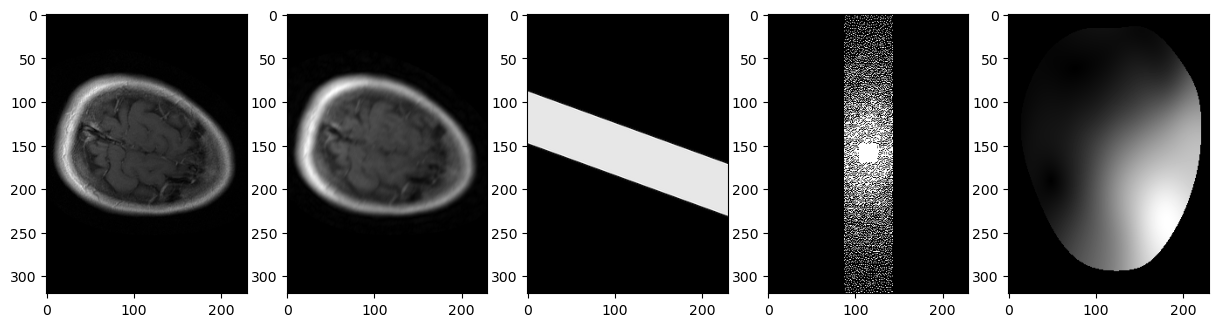

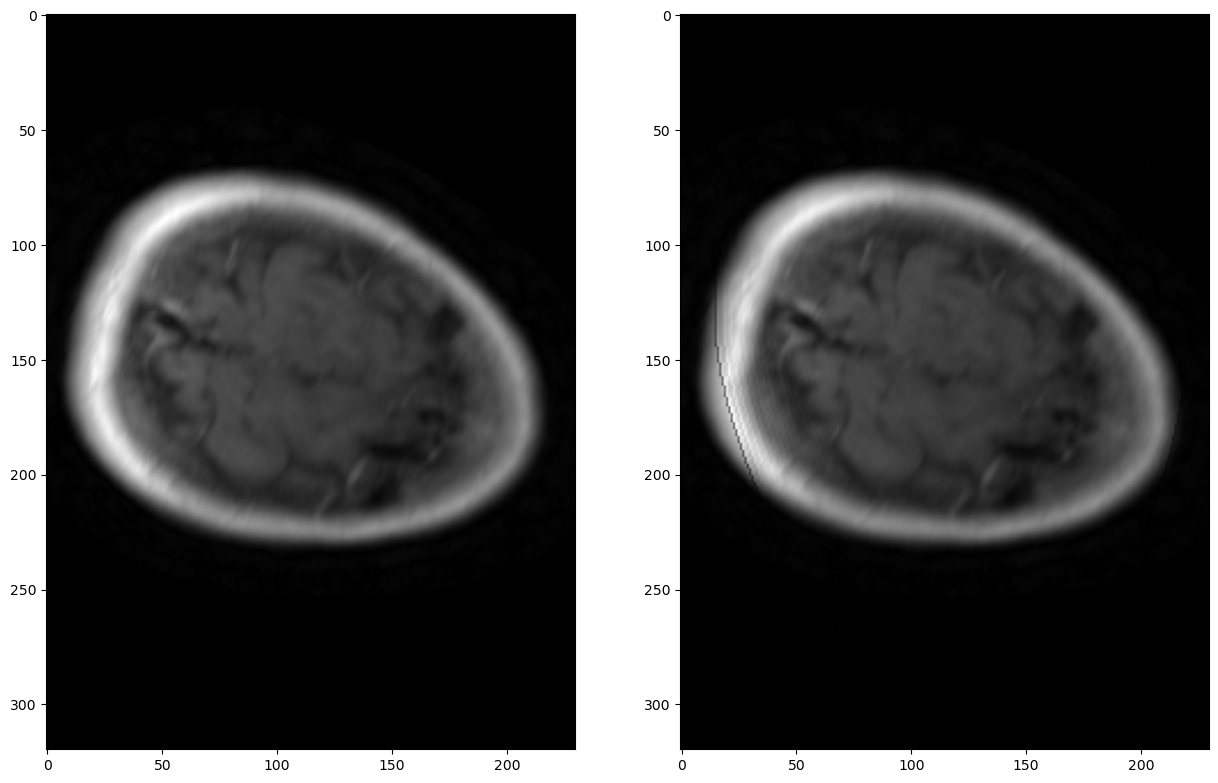

In [61]:
idx = 38
with h5py.File("/home/orel/projects/kband_debug/data/brain_data_400samples_val.h5", 'r') as F:
    imgs = np.array(F['imgs'][idx,...], dtype=np.complex)
    maps = np.array(F['maps'][idx,...], dtype=np.complex)
    ksp = np.array(F['ksp'][idx,...], dtype=np.complex)

with h5py.File("/home/orel/projects/kband_debug/data/brain_vertical2d_Rv4_Rb4_val.h5", 'r') as F:
    masks = np.array(F['masks'][idx,...], dtype=np.float)
    loss_masks = np.array(F['loss_masks'][idx, ...], dtype=np.float)
    if 'noise' in F.keys():
        noise = np.array(F['noise'][idx,...], dtype=np.complex)
    else:
        noise = None

imgs = imgs[None,...]
maps = maps[None,...]
ksp = ksp[None,...]
masks = masks[None,...]
loss_masks = loss_masks[None,...]

print(f"imgs       =   {imgs.shape}")
print(f"masks      =   {masks.shape}")
print(f"loss_masks =   {loss_masks.shape}")
print(f"maps       =   {maps.shape}")
print(f"ksp        =   {ksp.shape}")


rotation_angle = 70
reshape = False
imgs = rotate(imgs, rotation_angle, axes=(1, 2), reshape=reshape)
# masks = rotate(masks, rotation_angle, axes=(1, 2), reshape=reshape)
loss_masks = rotate(loss_masks, rotation_angle, axes=(1, 2), reshape=reshape)
# maps = rotate(maps, rotation_angle, axes=(2, 3), reshape=reshape)
# ksp = rotate(ksp, rotation_angle, axes=(2, 3), reshape=reshape)


print(f"imgs       =   {imgs.shape}")
print(f"masks      =   {masks.shape}")
print(f"loss_masks =   {loss_masks.shape}")
print(f"maps       =   {maps.shape}")
print(f"ksp        =   {ksp.shape}")

noise = np.random.randn(*maps.shape) + 1j * np.random.randn(*maps.shape)
out = masks[None,...] * (ksp + 1 / np.sqrt(2) * 0.01 * noise)
out = np.sum(np.conj(maps) * ifft2uc(out), axis=1)

out = rotate(out, rotation_angle, axes=(1, 2), reshape=reshape)
print(f"out        =   {out.shape}")
import matplotlib.pyplot as plt


plt.figure(figsize=(15,15))

plt.subplot(1,5,1)
plt.imshow(np.abs(imgs[0]), cmap="gray")


plt.subplot(1,5,2)
plt.imshow(np.abs(out[0]), cmap="gray")



plt.subplot(1,5,3)
plt.imshow(np.abs(loss_masks[0]), cmap="gray")


plt.subplot(1,5,4)
plt.imshow(np.abs(masks[0]), cmap="gray")

plt.subplot(1,5,5)
plt.imshow(np.abs(maps[0,1]), cmap="gray")

# imgs = rotate(imgs, rotation_angle, axes=(1, 2), reshape=reshape)
print(f"loss       =   {_kband_l1_loss_fun(torch.tensor(out), torch.tensor(imgs), torch.tensor(loss_masks)).item()}")


l2lam = 0.001

out = torch.tensor(out)
maps = torch.tensor(maps)
masks = torch.tensor(masks)

A = MultiChannelMRI(maps, masks, l2lam=0., img_shape=imgs.shape, use_sigpy=False, noncart=False)
x_adj = out
cg_op = ConjGrad(x_adj + l2lam * out, A.normal, l2lam=l2lam, max_iter=10, eps=0.0001, verbose=False)


x = cg_op.forward(out)

for i in range(20):
    x = cg_op.forward(x)

x = x.detach().cpu()

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(np.abs(out[0]), cmap="gray")

plt.subplot(1,2,2)
plt.imshow(np.abs(x[0]), cmap="gray")

print("done")

cong1_input.pt                                100%  576KB 822.4KB/s   00:00    
cong1.pt                                      100%  576KB 539.5KB/s   00:01    
cong2.pt                                      100%  576KB 951.2KB/s   00:00    
x_adj.pt                                      100%  576KB 945.8KB/s   00:00    
maps.pt                                       100% 9201KB   1.0MB/s   00:08    
mask.pt                                       100%  288KB 719.1KB/s   00:00    
brain_data_400samples_val.h5	 cong1_input.pt  cong2.pt  mask.pt
brain_vertical2d_Rv4_Rb4_val.h5  cong1.pt	 maps.pt   x_adj.pt


/home/orel/anaconda3/envs/k-band3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/orel/anaconda3/envs/k-band3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/orel/anaconda3/envs/k-band3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


done


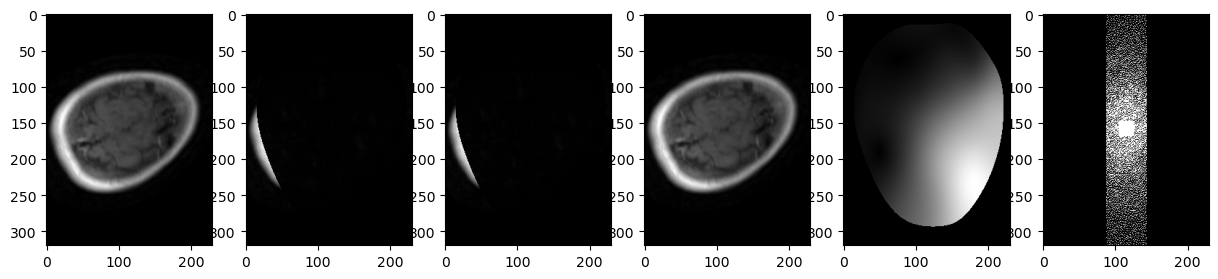

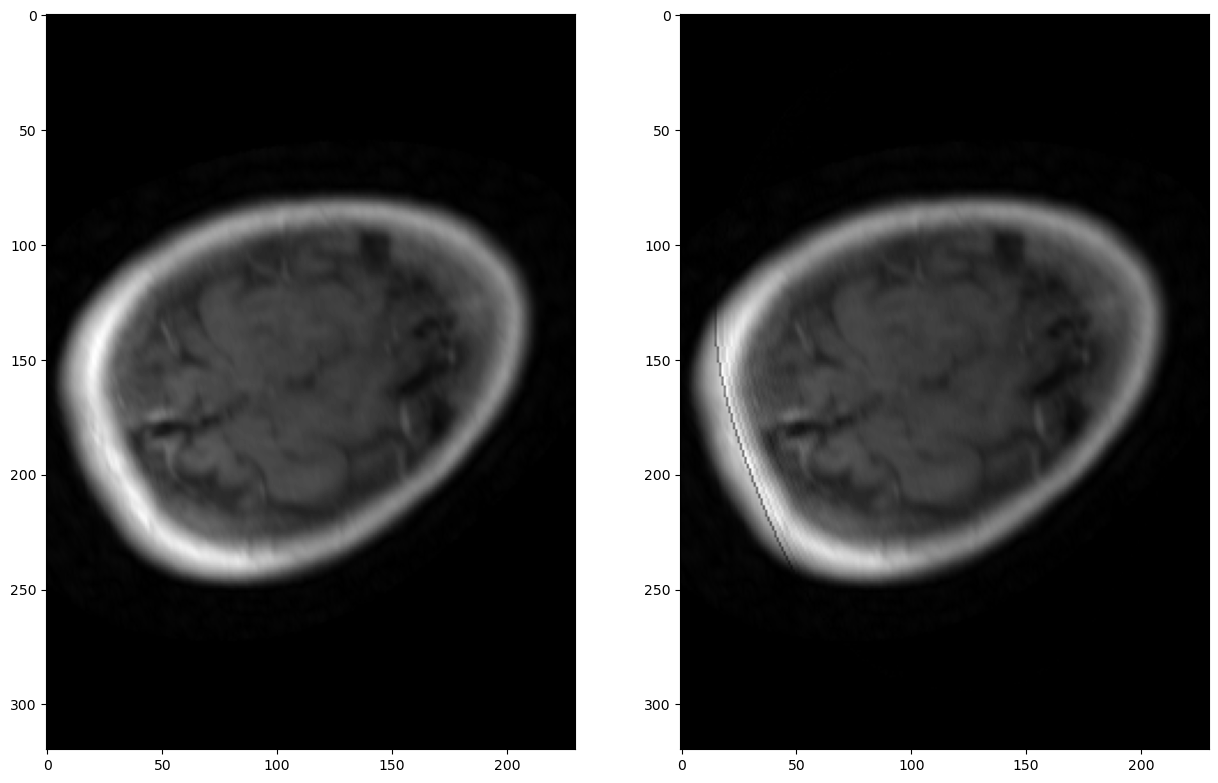

In [63]:
!scp orel.ts@dgx-master.technion.ac.il:/home/orel.ts/work/fastMRIdata/debug/cong1_input.pt /home/orel/projects/kband_debug/data/
!scp orel.ts@dgx-master.technion.ac.il:/home/orel.ts/work/fastMRIdata/debug/cong1.pt /home/orel/projects/kband_debug/data/
!scp orel.ts@dgx-master.technion.ac.il:/home/orel.ts/work/fastMRIdata/debug/cong2.pt /home/orel/projects/kband_debug/data/
!scp orel.ts@dgx-master.technion.ac.il:/home/orel.ts/work/fastMRIdata/debug/x_adj.pt /home/orel/projects/kband_debug/data/
!scp orel.ts@dgx-master.technion.ac.il:/home/orel.ts/work/fastMRIdata/debug/maps.pt /home/orel/projects/kband_debug/data/
!scp orel.ts@dgx-master.technion.ac.il:/home/orel.ts/work/fastMRIdata/debug/mask.pt /home/orel/projects/kband_debug/data/
!ls /home/orel/projects/kband_debug/data/

cong1_input = torch.load("/home/orel/projects/kband_debug/data/cong1_input.pt").detach().cpu()
cong1 = torch.load("/home/orel/projects/kband_debug/data/cong1.pt").detach().cpu()
cong2 = torch.load("/home/orel/projects/kband_debug/data/cong2.pt").detach().cpu()
x_adj = torch.load("/home/orel/projects/kband_debug/data/x_adj.pt").detach().cpu()
maps_load = torch.load("/home/orel/projects/kband_debug/data/maps.pt").detach().cpu()
mask_load = torch.load("/home/orel/projects/kband_debug/data/mask.pt").detach().cpu()


plt.figure(figsize=(15,15))

plt.subplot(1,6,1)
plt.imshow(np.abs(cong1_input[0]), cmap="gray")

plt.subplot(1,6,2)
plt.imshow(np.abs(cong1[0]), cmap="gray")

plt.subplot(1,6,3)
plt.imshow(np.abs(cong2[0]), cmap="gray")

plt.subplot(1,6,4)
plt.imshow(np.abs(x_adj[0]), cmap="gray")

plt.subplot(1,6,5)
plt.imshow(np.abs(maps_load[0,1]), cmap="gray")

plt.subplot(1,6,6)
plt.imshow(np.abs(mask_load[0]), cmap="gray")



l2lam = 0.001
inp = torch.tensor(x_adj)
maps_load = -torch.tensor(maps_load)
mask_load = -torch.tensor(mask_load)

A = MultiChannelMRI(maps, masks, l2lam=0., img_shape=imgs.shape, use_sigpy=False, noncart=False)

cg_op = ConjGrad(inp + l2lam * inp, A.normal, l2lam=l2lam, max_iter=10, eps=0.0001, verbose=False)
x = cg_op.forward(inp)
for i in range(20):
    x = cg_op.forward(x)

x = x.detach().cpu()

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(np.abs(inp[0]), cmap="gray")

plt.subplot(1,2,2)
plt.imshow(np.abs(x[0]), cmap="gray")

print("done")



IndexError: index 255 is out of bounds for dimension 1 with size 16

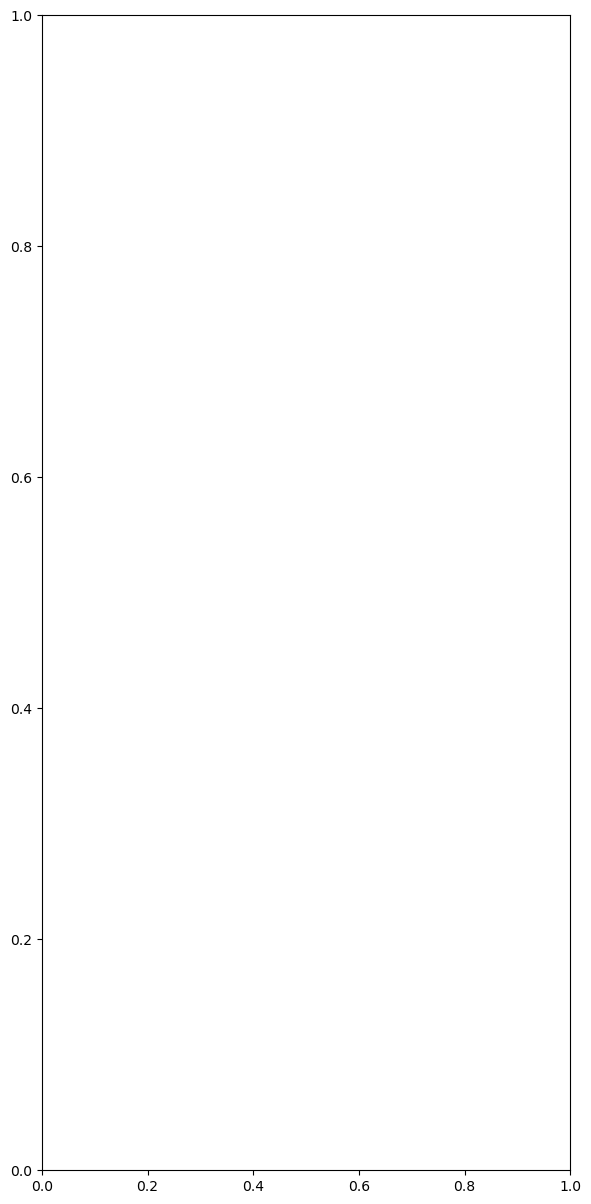

In [73]:
plt.figure(figsize=(15,15))
idx = 13
plt.subplot(1,2,1)
plt.imshow(np.abs(maps[0,idx]), cmap="gray")

plt.subplot(1,2,2)
plt.imshow(np.abs(maps_load[0,idx]), cmap="gray")


print(maps[0,0,121,160])
print(maps_load[0,0,121,160])
